In [1]:
#!pip install opencv-python
#!pip install pillow

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym 
import random

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [3]:
class LepScape(Env):
    def __init__(self):
        super(LepScape, self).__init__()
        
        
        #Define a 2-D observation space
        self.observation_shape=(500, 500, 1)
        self.observation_space = spaces.Box(low=0,
                                            high = 255,
                                            shape=(500, 500, 1),
                                            dtype = np.uint8)
        
        # Define an action space ranging from 0 to 6
        self.action_space = spaces.Discrete(7)
        
        # Create a canvas to render the environment images upon
        self.canvas= np.ones((500, 500, 1), dtype=np.uint8)
    
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum bullets leprechaun can take at once
        self.max_bullets = 25
        
        # Permissible area of leprechaun to be
        self.y_min = 0
        self.x_min = 0
        
        self.y_max = self.observation_shape[0]
        self.x_max = self.observation_shape[1]
        
        # episode length in timesteps
        self.ep_length =256
        
    def draw_elements_on_canvas(self):
        # Init the canvas 
        #self.canvas = np.ones(self.observation_shape) * 1
        self.canvas= np.ones((500, 500, 1), dtype=np.uint8)

        # Draw the leprechaun on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon
            
        
#         shld grayscale and remove for training
#         text = 'bullets Left: {} | Rewards: {} | time left: {}'.format(self.bullets_left, self.ep_return, self.ep_length)

#         # Put the info on canvas 
#         self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
#                    0.8, (255,255,255), 1, cv2.LINE_AA)

    def reset(self):
        #reset the time
        self.ep_length = 256
        
        # Reset the bullets used
        self.bullets_left = self.max_bullets

        # Reset the reward
        self.ep_return  = 0

        # Number of bugs and ammo
        self.bug_count = 0
        self.ammo_count = 0

        # leprechaun spawns in bottom middle of the screen
        x = int(self.observation_shape[0]/2)
        y = self.y_max 
        
        #initialize background
        self.bg=Bg("bg",self.x_max, self.x_min, self.y_max, self.y_min)
        xbg=0
        ybg= 0
        self.bg.set_position(xbg, ybg)

        # Intialise the leprechaun
        self.leprechaun = Leprechaun("leprechaun", self.x_max, self.x_min, self.y_max, self.y_min)
        self.leprechaun.set_position(x,y)
        
       

        # Intialise the elements 
        self.elements = [self.bg, self.leprechaun]
        #self.elements = [self.leprechaun]

        # Reset the Canvas 
        #self.canvas = np.ones(self.observation_shape) * 1
        self.canvas= np.ones((500, 500, 1), dtype=np.uint8)

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        return self.canvas
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
    
    
    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4:"shoot", 5: "Do Nothing"}
    
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False
    
    
    def step(self, action):
        # Flag that marks the termination of an episode
        done = False

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the time 
        self.ep_length -= 1 

        # Reward for executing a step (agent gets small penalty  for continue to exist without doing anything notable) .
        reward = -0.0001      

        # apply the action to the leprechaun
        if action == 0:
            self.leprechaun.move(0,5)
        elif action == 1:
            self.leprechaun.move(0,-5)
        elif action == 2:
            self.leprechaun.move(5,0)
        elif action == 3:
            self.leprechaun.move(-5,0)
        elif action == 4:
            if self.bullets_left>0:
                 # Spawn a bullet
                spawned_bullet = Bullet("bullet_{}".format(self.bullets_left), self.x_max, self.x_min, self.y_max, self.y_min)
                self.bullets_left -= 1

                bullet_x, bullet_y = self.leprechaun.get_position()
                spawned_bullet.set_position(bullet_x, bullet_y)

                # Append the spawned bullet to the elements currently present in Env. 
                self.elements.append(spawned_bullet) 
                spawned_bullet.move(0,-5)
                #small penalty for firing a bullet
                reward-=0.5
        elif action == 5:
            pass

        # Spawn a bug at the top edge with prob 0.01
        if random.random() < 0.2:

            # Spawn a bug
            spawned_bug = Bug("bug_{}".format(self.bug_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.bug_count += 1

            # Compute the x,y co-ordinates of the position from where the bug has to be spawned
            # Horizontally, the position randomly and vertically, the bug is spawned at the top edge 
            # sampled from the set of permissible values            
            bug_x = random.randrange(self.x_min, self.x_max)
            bug_y = self.y_min
            spawned_bug.set_position(bug_x, bug_y)

            # Append the spawned bug to the elements currently present in Env. 
            self.elements.append(spawned_bug)    

        # Spawn an ammo pack at the top edge with prob 0.01
        if random.random() < 0.01:
            # Spawn an ammo pack
            spawned_ammo = Ammo("ammo_{}".format(self.ammo_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.ammo_count += 1

            # Compute the x,y co-ordinates of the position from where the ammo pack has to be spawned
            # Horizontally, the position is randomly chosen from the list of permissible values and 
            # vertically, the position is at the top edge            
            ammo_x = random.randrange(self.x_min, self.x_max)
            ammo_y = self.y_min
            spawned_ammo.set_position(ammo_x, ammo_y)

            # Append the spawned ammo to the elemetns currently present in the Env.
            self.elements.append(spawned_ammo)   

        
        #check for bug collisions with bullet and update reward 
        current_bullets= [elem for elem in self.elements if isinstance(elem, Bullet)]
        current_bugs=[elem for elem in self.elements if isinstance(elem, Bug)]
        
        for elem in self.elements:
            if isinstance(elem, Bug):
                for bullet in current_bullets:
                    if self.has_collided(bullet, elem):
                        #remove the bug and the bullet from screen
                        #print(elem, bullet)
                        #catch list removal errors#deal later
                        try: 
                            self.elements.remove(elem)
                            self.elements.remove(bullet)
                            #large reward for killing bug
                            reward +=5
                        except Exception as e:
                            pass
                            #print("element removal error", e)

        #update rest of elements                    
        for elem in self.elements:
            if isinstance(elem, Bug): 
                # If the bug has reached the bottom edge, remove it from the Env
                if elem.get_position()[1] >= self.y_max-elem.icon_w:
                    #print(elem.get_position()[1])
                    self.elements.remove(elem)
                else:
                    # Move the bug down by 5 pts.
                    #print(elem.get_position()[1],"down", self.y_max)
                    elem.move(0,5)

                # If the bug has collided with the leprechaun end the episode
                if self.has_collided(self.leprechaun, elem):
                    # Conclude the episode and remove the lep from the Env.
                    done = True
                    #large penalty for colliding with bug
                    reward -=10
                    self.elements.remove(self.leprechaun)
                
                        

            if isinstance(elem, Ammo):
                # If the ammo pack has reached the bottom, remove it from the Env
                if elem.get_position()[1] >= self.y_max-elem.icon_w:
                    self.elements.remove(elem)
                else:
                    # Move the ammo down by 5 pts.
                    elem.move(0, 5)

                # If the ammo pack has collided with the leprechaun.
                if self.has_collided(self.leprechaun, elem):
                    try: 
                        # Remove the ammo pack from the env.
                        self.elements.remove(elem)
                        reward +=1
                        # update ammo left of the leprechaun to full.
                        self.bullets_left = self.max_bullets
                    except Exception as e:
                        pass
                        #print("element removal error", e)

            if isinstance(elem, Bullet):
                # If the bullet has reached the top edge, remove it from the Env
                if elem.get_position()[1] <= self.y_min:
                    self.elements.remove(elem)
                else:
                    # Move the bullet up by 5 pts.
                    elem.move(0, -5)


        # Increment the episodic return
        self.ep_return += reward

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of time, end the episode.
        if self.ep_length == 0:
            done = True

        return self.canvas, reward, done, {}

In [4]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
        
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [5]:
class Leprechaun(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Leprechaun, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("lep2.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))
    
class Bug(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bug, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bug.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))
    
class Ammo(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Ammo, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("ammo.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))

class Bullet(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bullet, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("shamrock.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 10
        self.icon_h = 10
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))

class Bg(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bg, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bg.jpg")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = x_max
        self.icon_h = y_max
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))

In [6]:
# #image testing
# data = cv2.imread("bg.jpg")
# print(data.shape)
# data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
# print(data)
# #data = 255.0 * data # Now scale by 255
# data = data[:, :, np.newaxis]
# print(data)
# data= cv2.resize(data, (500,500), interpolation=cv2.INTER_CUBIC)
# data=np.reshape(data, (500,500,1))
# # print(type(data))
# # print(type(data))
# # info = np.finfo(data.dtype) # Get the information of the incoming image type
# # data = data.astype(np.float64) / info.max # normalize the data to 0 - 1
# #data = 255 * data # Now scale by 255
# # img = data.astype(np.uint8)
# cv2.imshow('Window', data)
# cv2.waitKey(10)

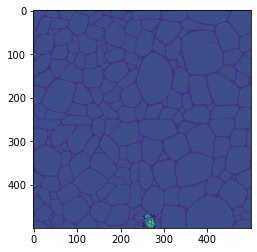

In [7]:
env = LepScape()
obs = env.reset()
screen = env.render(mode = "rgb_array")
plt.imshow(screen)

In [8]:
# test env
from IPython import display

env = LepScape()
obs = env.reset()

#try:
while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render()

    #     # Render the game
    #     screen=lambda : plt.imshow(env.render(mode = "rgb_array"))
    #     screen()

    if done == True:
        break
#except Exception as e:
  #print("An exception occurred", e)
  #env.close()


env.close()

# Training the Leprechaun Environment

# View Game State

In [64]:
env.reset()

array([[[59],
        [58],
        [57],
        ...,
        [60],
        [60],
        [59]],

       [[59],
        [58],
        [58],
        ...,
        [59],
        [60],
        [59]],

       [[59],
        [58],
        [58],
        ...,
        [59],
        [60],
        [59]],

       ...,

       [[58],
        [58],
        [58],
        ...,
        [59],
        [58],
        [58]],

       [[58],
        [58],
        [58],
        ...,
        [59],
        [58],
        [58]],

       [[58],
        [58],
        [58],
        ...,
        [59],
        [58],
        [58]]], dtype=uint8)

In [65]:
env.close()

In [66]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [67]:
# no oissur
env_checker.check_env(env)

## Setup Callback

In [68]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [69]:
#!pip install stable-baselines3[extra]

In [70]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [72]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [73]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [74]:
callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

# Train Model

In [75]:
# import ppo for training
from stable_baselines3 import PPO

In [76]:
# Non rendered environment
env = LepScape()

In [77]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=1024)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [53]:
#model.load('./train/train_basic/best_model_15000')

In [54]:
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_basic\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 218      |
|    ep_rew_mean     | 26.7     |
| time/              |          |
|    fps             | 10       |
|    iterations      | 1        |
|    time_elapsed    | 94       |
|    total_timesteps | 1024     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 204        |
|    ep_rew_mean          | 18.2       |
| time/                   |            |
|    fps                  | 1          |
|    iterations           | 2          |
|    time_elapsed         | 1344       |
|    total_timesteps      | 2048       |
| train/                  |            |
|    approx_kl            | 0.06326077 |
|    clip_fraction        | 0.388      |
|    clip_range 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 199        |
|    ep_rew_mean          | 13.5       |
| time/                   |            |
|    fps                  | 0          |
|    iterations           | 11         |
|    time_elapsed         | 12677      |
|    total_timesteps      | 11264      |
| train/                  |            |
|    approx_kl            | 0.08697997 |
|    clip_fraction        | 0.42       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.77      |
|    explained_variance   | 0.316      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.101     |
|    n_updates            | 240        |
|    policy_gradient_loss | -0.0952    |
|    value_loss           | 1.12       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 199        |
|    ep_rew_mean

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 57032704 bytes.

# Test the Model

In [22]:
import os

In [23]:
print(os.getcwd())

C:\Users\Nicholas\Desktop\CCT\lep_env


In [24]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [78]:
# Reload model from disc
model = PPO.load('./train/train_basic/best_model_15000')

In [26]:
# Create rendered environment
env = LepScape()
#obs = env.reset()

In [ ]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)

In [ ]:
mean_reward

In [ ]:
model.predict(obs)

In [27]:
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        
        env.render()
        # time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    #time.sleep(1)

Total Reward for episode 22.974400000000003 is 0
Total Reward for episode -4.518599999999996 is 1
Total Reward for episode -2.525600000000017 is 2
Total Reward for episode 24.97440000000002 is 3
Total Reward for episode 5.4847000000000055 is 4
Total Reward for episode -1.5098000000000056 is 5
Total Reward for episode -4.5127999999999995 is 6
Total Reward for episode 2.986300000000009 is 7
Total Reward for episode 24.475900000000014 is 8
Total Reward for episode 0.990199999999998 is 9
